In [ ]:
"""
Evaluate models created. This file evaluates the models trained 
by plotting their latent spaces and examining how they correspond
with synthezability access scores, qeds, and logps. It also evaluates
the efficacy of the decoding by reporting how often the smiles are reported
back as valid and unique using GuacaMol:
https://www.benevolent.com/research/guacamol-benchmarking-models-for-de-novo-molecular-design
It also examines how unique or novel smiles can be generated using multiple 
decoding attempts. 
"""

In [ ]:
# Initialize drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Move to Google Drive 
%cd drive
%cd 'My Drive'
%cd 'MSc Stats Dissertation'

/content/drive
/content/drive/My Drive
/content/drive/My Drive/MSc Stats Dissertation


In [ ]:
!pip install deepsmiles
!pip install selfies
!pip install guacamol
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

  Using cached deepsmiles-1.0.1-py2.py3-none-any.whl (12 kB)


'!pip install selfies\n!pip install guacamol\n!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh\n!chmod +x Miniconda3-latest-Linux-x86_64.sh\n!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local\n!time conda install -q -y -c conda-forge rdkit'

In [ ]:
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

"import sys\nimport os\nsys.path.append('/usr/local/lib/python3.7/site-packages/')"

In [ ]:
import numpy as np
import deepsmiles
import tensorflow as tf
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras as keras
import pandas as pd
import math
import tensorflow.keras.layers as layers
import rdkit
import Utils.generate_utils as generate_utils
import time
import numpy as np
import matplotlib.pyplot as plt
from guacamol.distribution_learning_benchmark import ValidityBenchmark, \
    UniquenessBenchmark, NoveltyBenchmark, KLDivBenchmark
from selfies import encoder, decoder, selfies_alphabet  


## Import models for evaluation 
import GANS.renewed_smiles_vae as renewed_smiles_vae
import GANS.implicitvae as implicitvae
import GANS.decoderTransformerLatent as decoderTransformerLatent
import GANS.ic50vae as ic50vae
import GANS.ic50pred as ic50pred


## Neccesary CONSTANTS
BATCH_SIZE = 256
VOCAB_SIZE = len(vocab_index)
EPOCHS = 10
PAD_SIZE = 250
MAX_LEN = PAD_SIZE -1
DROP_OUT= 0.2
EMBEDDING_DIM = 192  ## Embedding dim of the characters
HIDDEN_DIM = 256
DROPOUT = 0.2
TRAIN = False
LATENT_DIM = 64
DEEP = True
SELFIES = False
IMPLICIT = False
PROPPRED = False 
TRANSFORMER_DECODE = False

'import tensorflow as tf\nimport tensorflow.keras.backend as K\nimport tensorflow.keras as keras\nimport pandas as pd\nimport math\nimport tensorflow.keras.layers as layers\nimport rdkit\nimport Utils.generate_utils as generate_utils\nimport time\nimport numpy as np\nimport matplotlib.pyplot as plt\nfrom guacamol.distribution_learning_benchmark import ValidityBenchmark,     UniquenessBenchmark, NoveltyBenchmark, KLDivBenchmark\nfrom selfies import encoder, decoder, selfies_alphabet  \n'

In [ ]:
## Import Necessary Data for training
train_smiles_X = np.load('./vocab/train_deep_smiles_X.npy',allow_pickle=True)
vocab =np.load('./vocab/deep_vocab.npy',allow_pickle=True)
vocab_index = np.load('./vocab/deep_vocab_index.npy',allow_pickle=True)
vocab = dict(vocab.ravel()[0])
vocab_index = dict(vocab_index.ravel()[0])

sas = np.load('./vocab/sas.npy',allow_pickle=True)
qed =np.load('./vocab/qed.npy',allow_pickle=True)
logp =np.load('./vocab/logp.npy',allow_pickle=True)

In [ ]:
index = np.where(train_smiles_X == 1)
t = np.split(train_smiles_X,index[0].tolist())
t= t[1:]
t = tf.keras.preprocessing.sequence.pad_sequences(t,maxlen = PAD_SIZE,padding='post')
NUM_BATCHES = math.floor(len(t)/BATCH_SIZE )
NUM_TRAIN_BATCH = math.floor(NUM_BATCHES*0.99)
NUM_TEST_BATCH = math.floor(NUM_BATCHES*(0.01))
test_X = t[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_X = t[:NUM_TRAIN_BATCH*BATCH_SIZE]

In [ ]:
test_sas = sas[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_sas = sas[:NUM_TRAIN_BATCH*BATCH_SIZE]

test_qed = qed[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_qed = qed[:NUM_TRAIN_BATCH*BATCH_SIZE]

test_logp = qed[NUM_TRAIN_BATCH*BATCH_SIZE:(NUM_TEST_BATCH+NUM_TRAIN_BATCH)*BATCH_SIZE]
train_logp = qed[:NUM_TRAIN_BATCH*BATCH_SIZE]


In [ ]:
## Import decoding transformer
transformer = decoderTransformerLatent.Transformer(embedding_dim=384,embedding_dropout =DROP_OUT,max_len=MAX_LEN,
                                                   num_heads = 6, num_layers = 6,
                      vocab_size = VOCAB_SIZE,attention_dropout =DROP_OUT,d_hid=EMBEDDING_DIM *4,use_one_embedding_dropout=False)

In [ ]:
transformer.load_weights('decoding_smiles_latent')

In [ ]:
if IMPLICIT:
  smile_vae = implicitvae.SMILE_IMPLICIT_VAE(vocab_size =VOCAB_SIZE,embedding_dim =EMBEDDING_DIM, 
              max_len =MAX_LEN, latent_dim=LATENT_DIM, hidden_dim= HIDDEN_DIM,
              recurrent_dropout =0.2,
              dropout_rate=0.2,
              epsilon_std = 1.0)
else:
    smile_vae = renewed_smiles_vae.SMILE_VAE(vocab_size= VOCAB_SIZE,embedding_dim=EMBEDDING_DIM, max_len= MAX_LEN, 
                     latent_dim = LATENT_DIM, recurrent_dropout = DROP_OUT,dropout_rate= DROP_OUT)

In [ ]:
if IMPLICIT:
  smile_vae.load_weights('smile_ivae_weights')
else:
  if DEEP:
    print('DEEP')
    smile_vae.load_weights('deep_conv_vae_weights2')
  elif SELFIES:
    smile_vae.load_weights('selfies_conv_vae_weights2')
  else:
    print('HERE')
    smile_vae.load_weights('smiles_conv_vae_weights2')

DEEP


In [ ]:
smile_vae = ic50vae.SMILE_VAE(vocab_size= VOCAB_SIZE,embedding_dim=EMBEDDING_DIM, max_len= MAX_LEN,
                     latent_dim = LATENT_DIM, recurrent_dropout = DROP_OUT,dropout_rate= DROP_OUT)
smile_vae.load_weights('ic50g_smile_conv_vae_weights')


In [ ]:
from typing import List

from guacamol.distribution_matching_generator import DistributionMatchingGenerator


class MockGenerator(DistributionMatchingGenerator):
    """
    Mock generator that returns pre-defined molecules,
    possibly split in several calls
    """

    def __init__(self, molecules: List[str]) -> None:
        self.molecules = molecules
        self.cursor = 0

    def generate(self, number_samples: int) -> List[str]:
        end = self.cursor + number_samples

        sampled_molecules = self.molecules[self.cursor:end]
        self.cursor = end
        return sampled_molecules

In [ ]:
## converts smiles to deep smiles 
def get_smiles_from_selfies(deep_list):
  smiles = []
  for deep in deep_list:
    try:
      smile = decoder(deep)
    except:
      smile = None
    smiles.append(smile)
  return smiles


In [ ]:
import re
## Replace individual characters with the 
## corresponding correct chemical 
def replace_halogens_inv(string):
  r = re.compile('R')
  l = re.compile('L')
  string = r.sub('Br', string)
  string = l.sub('Cl', string)
  return string

In [ ]:
## converts smiles to deep smiles 
def get_smiles_from_deep(deep_list):
  smiles = []
  print("DeepSMILES version: %s" % deepsmiles.__version__)
  converter = deepsmiles.Converter(rings = True, branches = True)
  print(converter) # record the options used
  i = 0 
  for deep in deep_list:
    try:
      smile = converter.decode(deep)
    except deepsmiles.DecodeError as e:
      smile = None
      print("DecodeError! Error message was '%s'" % e.message)
    if (i%100000 == 0 ):
      print(i)
    i+= 1
    smiles.append(smile)
  return smiles


In [ ]:
def get_smiles_from_logits_prob(logits,vocab_index, temperature =1.0):
  logits = logits/temperature
  #soft = tf.nn.softmax(logits, axis = -1)
  #prediction  = # tf.argmax(soft, -1) 
  text_generated = []
  for i in logits[0]:
    j = tf.random.categorical(tf.reshape(i,[1,len(i)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[j])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits(logits,vocab_index):
  soft = tf.nn.softmax(logits, axis = -1)
  prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for i in prediction[0]:
    text_generated.append(vocab_index[i.numpy()])
  if '<EOS>' in text_generated:
    eos_index = text_generated.index('<EOS>')
    text_generated = text_generated[:eos_index]
  else:
    text_generated = []
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_ismiles_from_logits(logits,vocab_index):
  soft = tf.nn.softmax(logits, axis = -1)
  prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for i in prediction[0]:
    text_generated.append(vocab_index[i.numpy()])
  bos_index = text_generated.index('<EOS>')
  text_generated = text_generated[0:bos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits_topp(logits,vocab_index,k =5):
  #soft = tf.nn.softmax(logits, axis = -1)
  #prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for log in logits[0]:
    ## sort predictions
    log = np.array(log)
    ind = np.array(log).argsort()[::-1][:(len(log))] ## Sort in descending order 
    sorted_prob = tf.nn.softmax(logits[ind])
    ## Get all the indicies that are less than the total allowed probability
    cumprob  = np.cumsum(sorted_prob)
    ind_stay = cumprob < p 
    if (len(ind_stay) <= 1):
      predicted_id = ind[0]
    else:
      sorted_logits = logits[ind]
      # using a categorical distribution to predict the character returned by the model
      predicted_index = tf.random.categorical(tf.reshape(sorted_logits,[1,len(sorted_logits)]), num_samples=1).numpy()
      predicted_id = ind[predicted_index][0][0]
    # using a categorical distribution to predict the character returned by the model
    #predicted_id = tf.random.categorical(tf.reshape(predictions,[1,len(predictions)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[ind[predicted_id]])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
## return smile string from logits
def get_smiles_from_logits_topk(logits,vocab_index,k =5):
  #soft = tf.nn.softmax(logits, axis = -1)
  #prediction  = tf.argmax(soft, -1) 
  text_generated = []
  for log in logits[0]:
    ## sort predictions
    log = np.array(log)
    ind = np.array(log).argsort()[::-1][:(len(log))] ## Sort in descending order 
    ## Get sorted predictions and the top k predictions
    log = log[ind]
    log = log[:k]
    # using a categorical distribution to predict the character returned by the model
    predicted_id = tf.random.categorical(tf.reshape(predictions,[1,len(predictions)]), num_samples=1)[0][0].numpy()
    text_generated.append(vocab_index[ind[predicted_id]])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return (''.join(text_generated))
  #print(''.join(text_generated))

In [ ]:
def get_smiles_from_tokens(tokens):
  text_generated = []
  for i in tokens:
    text_generated.append(vocab_index[i])
  eos_index = text_generated.index('<EOS>')
  text_generated = text_generated[:eos_index]
  return ''.join(text_generated)

In [ ]:
## Get testing data encoding and decoding 
test_smiles = []
index = 0 
for test_smile in test_X[:1000]:
  if index % 100 == 0:
    print(index)
  test_s = test_smile.reshape(1,test_smile.shape[0])[:,:-1] 
  if IMPLICIT:
    test_s_x = smile_vae.encoder(test_s)[1]
    if TRANSFORMER_DECODE == True:
      test_s_x = transformer(test_s_x,pos_embed,test_s)
    else:
      test_s_x = smile_vae(test_s)[0]
    test_smiles.append(get_ismiles_from_logits(test_s_x,vocab_index))
  else:
    test_s_x = smile_vae.encoder(test_s)[1]
    if TRANSFORMER_DECODE == True:
      test_s_x = transformer(test_s_x,pos_embed,test_s)
    else:
      test_s_x = smile_vae(test_s)[2]
    test_smiles.append(get_smiles_from_logits(test_s_x,vocab_index))
  index+=1
if DEEP:
  actual_smiles = get_smiles_from_deep(test_smiles)
elif SELFIES: 
  actual_smiles = get_smiles_from_selfies(test_smiles)
else: 
  actual_smiles = test_smiles

0
100
200
300
400
500
600
700
800
900
HERE
DeepSMILES version: 1.0.1
Converter(rings=True, branches=True)
0
DecodeError! Error message was 'There is no corresponding atom on which to place the ring opening symbol for the ring sized 11'
DecodeError! Error message was ''%' should be followed by two digits'
DecodeError! Error message was 'There is no corresponding atom on which to place the ring opening symbol for the ring sized 6'
DecodeError! Error message was 'There is no corresponding atom on which to place the ring opening symbol for the ring sized 6'
DecodeError! Error message was ''%' should be followed by two digits'
DecodeError! Error message was ''%' should be followed by two digits'
DecodeError! Error message was ''%' should be followed by two digits'
DecodeError! Error message was 'There is no corresponding atom on which to place the ring opening symbol for the ring sized 14'
DecodeError! Error message was 'Too many close parentheses - there is no corresponding atom to pop off

In [ ]:
correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
testing_set = [get_smiles_from_tokens(v[1:]) for i,v in enumerate(test_X[:1000])]
if DEEP:
  testing_set = get_smiles_from_deep(testing_set)
elif SELFIES:
  testing_set = get_smiles_from_selfies(testing_set)

if not SELFIES:
  for i in range(len(correct_smiles)):
    correct_smiles[i] = replace_halogens_inv(correct_smiles[i])

DeepSMILES version: 1.0.1
Converter(rings=True, branches=True)
0


In [ ]:

NUM_SAMPLES = len(correct_smiles)
### ASSESS NUMBER OF CORRECT SMILES
generator = MockGenerator(correct_smiles)
benchmark = ValidityBenchmark(number_samples=NUM_SAMPLES)
print("Percentage of correctly Generated SMILES: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))

## Asess generated strings
generator = MockGenerator(correct_smiles)
print(len(testing_set))
#training_set = molecules['Smiles'].tolist()

### Assess the number of unique SMILES generated
benchmark = UniquenessBenchmark(number_samples=NUM_SAMPLES)
print("The model's uniqueness score is: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))

### Assess the novelty of the SMILES generated
#generator = MockGenerator(['CCOCC', 'O(CC)CC', 'C=CC=C', 'CC'])
generator = MockGenerator(correct_smiles)

benchmark = NoveltyBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
#benchmark = NoveltyBenchmark(number_samples=NUM_SAMPLES, training_set=['CO', 'CC'])
print("The model's novelty score is: " + \
  "{:.3f}".format(benchmark.assess_model(generator).score))

## Assess the KL-Divergence of the SMILES generated 
#benchmark = KLDivBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
generator = MockGenerator(correct_smiles)
benchmark = KLDivBenchmark(number_samples=NUM_SAMPLES, training_set=testing_set)
result = benchmark.assess_model(generator)
print("The model's KL Divergence score is: " + \
      "{:.3f}".format(result.score))

Percentage of correctly Generated SMILES: 0.821
1000
The model's uniqueness score is: 0.821
The model's novelty score is: 0.289
The model's KL Divergence score is: 0.952


In [ ]:
def perturb_z( z, noise_norm, constant_norm=False):
  if noise_norm > 0.0:
    noise_vec = np.random.normal(0, 1, size=z.shape)
    noise_vec = noise_vec / np.linalg.norm(noise_vec)
    if constant_norm:
      return z + (noise_norm * noise_vec)
    else:
      noise_amp = np.random.uniform(
          0, noise_norm, size=(z.shape[0], 1))
      return z + (noise_amp * noise_vec)
  else:
    return z

In [ ]:
def smile_to_smiles(smile_vae,
                    smile,
                    vocab_index,
                    noise_norm =0.1,
                    decode_attempts=250):
  h, z_mean,z_log_var  = smile_vae.encoder(tf.reshape(smile,[1,MAX_LEN]))
  zs = []
  for i in range(decode_attempts):
    #zs.append(tf.keras.layers.Lambda(smile_vae.encoder.sample, output_shape =(z_log_var.shape[1],))([z_mean,z_log_var]))
    zs.append(perturb_z(z_mean,0))
    #zs.append(perturb_z(z_mean,0.1))
  zs = np.array(zs)
  zs = zs.reshape((zs.shape[0],zs.shape[-1]))
  #print(zs.shape)
  x_decoded = []
  #for z in zs:
  x_decoded = smile_vae.decoder(zs)
  decoded_smiles = []
  for x_dec in x_decoded:
    decoded_smiles.append(get_smiles_from_logits(tf.reshape(x_dec,[1,MAX_LEN,VOCAB_SIZE]),vocab_index))
  actual_smiles = decoded_smiles
  print(decoded_smiles)
  if DEEP == True:
    actual_smiles = get_smiles_from_deep(decoded_smiles)
    correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None]
  elif SELFIES:
    actual_smiles = get_smiles_from_selfies(decoded_smiles)
    correct_smiles =[v for i,v in enumerate(actual_smiles) if v != None]
  else:
    correct_smiles =[replace_halogens_inv(v) for i,v in enumerate(actual_smiles) if v != None]
  num_samples = len(correct_smiles)
  generator = MockGenerator(correct_smiles)
  benchmark = ValidityBenchmark(number_samples=num_samples)
  print("Percentage of correctly Generated SMILES: " + \
    "{:.3f}".format(benchmark.assess_model(generator).score))

  generator = MockGenerator(correct_smiles)
  benchmark = UniquenessBenchmark(number_samples=num_samples)
  print("The model's uniqueness score is: " + \
    "{:.3f}".format(benchmark.assess_model(generator).score))
  
  return correct_smiles

In [ ]:
from sklearn.decomposition import KernelPCA
NUM_SAMPLED = 4000
sampled_index = np.random.choice(len(train_X), NUM_SAMPLED , replace=False)
sampled_points =[]
qeds = []
sass = []
logps = []
for i in sampled_index:
  t = smile_vae(train_X[i][:-1].reshape(1,MAX_LEN))[1]
  sampled_points.append(t) 
  qeds.append(train_qed[i])
  sass.append(train_sas[i])
  logps.append(train_logp[i])
sampled_points = np.array(sampled_points).reshape(NUM_SAMPLED,LATENT_DIM)
PCA = KernelPCA(n_components=2, kernel="linear")
data_transformed = PCA.fit_transform(sampled_points)
from sklearn.preprocessing import MinMaxScaler
scaler1 = MinMaxScaler()
scaler1.fit(np.array(data_transformed[:,0]).reshape(-1,1))
scaler2 = MinMaxScaler()
scaler2.fit(np.array(data_transformed[:,1]).reshape(-1,1))

plot  = {0: [scaler1.transform(x[0].reshape(1,-1))[0][0] for x in data_transformed],
             1: [scaler2.transform(x[1].reshape(1,-1))[0][0] for x in data_transformed]}


(-0.0499999981197677, 1.0500000018802325, -0.05, 1.05)

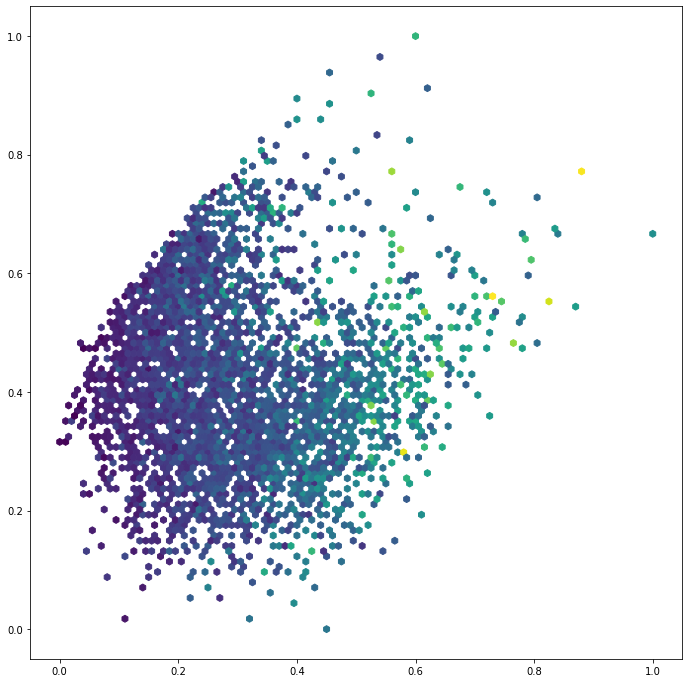

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
im = ax.hexbin(plot[0], plot[1],C =sass , reduce_C_function=np.mean)#,C=sass)#,reduce_C_function=np.mean)
plt.xlim(-3, 3)
plt.ylim(-1, 10)

#fig.colorbar(im, ax=ax)
#_ = fig.suptitle('Latent Space of Drug Data', fontsize=20)
#_ = fig.text(0.5, 0.05, 'Principal Component 1', ha='center', fontsize=14)
#_ = fig.text(0.02, 0.5, 'Principal Component 2', ha='center', fontsize=14, rotation=90)
#_ = fig.legend(fontsize=16)
plt.axis('square')


In [ ]:
fig.savefig("./Figures/circular_sas_deep_smiles_Latent_Space_Conv_VAE.pdf", bbox_inches='tight')

In [ ]:
import umap
fit = umap.UMAP()
%time u = fit.fit_transform(sampled_points)
scaler1 = MinMaxScaler()
scaler1.fit(np.array(u[:,0]).reshape(-1,1))
scaler2 = MinMaxScaler()
scaler2.fit(np.array(u[:,1]).reshape(-1,1))

plot  = {0: [scaler1.transform(x[0].reshape(1,-1))[0][0] for x in u],
             1: [scaler2.transform(x[1].reshape(1,-1))[0][0] for x in u]}


CPU times: user 32.2 s, sys: 265 ms, total: 32.4 s
Wall time: 24 s


MinMaxScaler(copy=True, feature_range=(0, 1))

(-0.05000000110000001, 1.0500000011000001, -0.05, 1.0500000022)

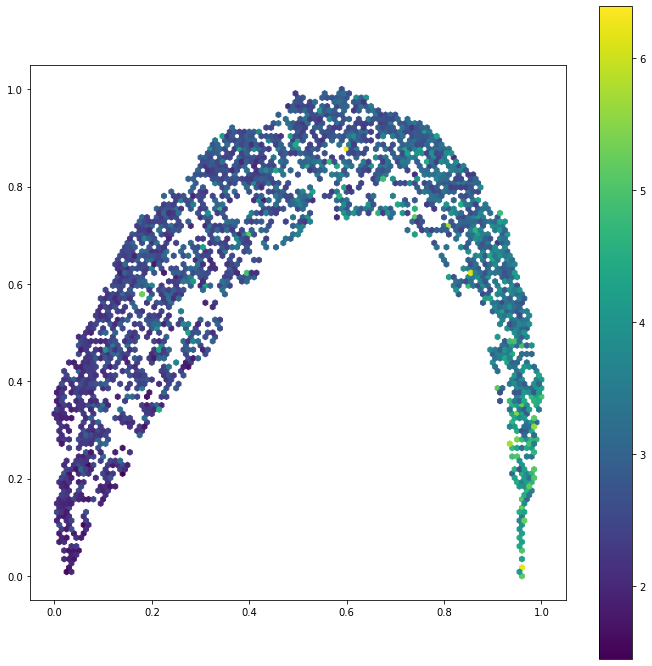

In [ ]:
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
im = ax.hexbin(plot[0], plot[1],C =sass , reduce_C_function=np.mean)#,cmap = 'RdPu')
plt.xlim(-3, 3)
plt.ylim(-1, 10)

fig.colorbar(im, ax=ax)
#_ = fig.suptitle('Latent Space of Drug Data', fontsize=20)
#_ = fig.text(0.5, 0.05, 'Principal Component 1', ha='center', fontsize=14)
#_ = fig.text(0.02, 0.5, 'Principal Component 2', ha='center', fontsize=14, rotation=90)
#_ = fig.legend(fontsize=16)
plt.axis('square')





In [ ]:
fig.savefig("./Figures/umap_circular_sas_ic50g_deep_smiles_Latent_Space_Conv_VAE.pdf", bbox_inches='tight')